# Gymnasium library / Cliff walk

[Gymnasium](https://gymnasium.farama.org/) is a Python library that provides a standardized API for reinforcement learning environments and many different example implementations.

The environment API is described in detail in the [documentation](https://gymnasium.farama.org/api/env/).

Below is an example using the cliff walk implementation from the library.

In [1]:
# The library used to be called `gym`
import gymnasium as gym

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline

# For SARSA/Q-learning
import numpy as np
from collections import defaultdict

In [2]:
# Create the environment by calling `gym.make` with its name
# Optionally, we can specify how to render the environment
env = gym.make("CliffWalking-v0", render_mode='ansi')

# Before using the environment we need to .reset() it
env.reset()

# The 'ansi' render mode returns a string representation of the world
print(env.render())

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T




In [3]:
# Actions can be taken using the .step() method
ret = env.step(1)

print(env.render())

print(ret)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


(36, -100, False, False, {'prob': 1.0})


For use in RL algorithms, the `reset` and `step` methods return the new state (or "observation"), the reward, whether the episode is terminated/truncated, and additional information.

In [4]:
(obs, info) = env.reset()
print(obs)
print(info)

36
{'prob': 1}


In [5]:
tmp = env.step(0)
tmp

(24, -1, False, False, {'prob': 1.0})

In [6]:
(obs, reward, terminated, truncated, info) = env.step(0)
print(obs)
print(reward)
print(terminated)
print(truncated)
print(info)

12
-1
False
False
{'prob': 1.0}


In [7]:
# Store remaining return values in list called `_` -> ignored
(obs, reward, terminated, *_) = env.step(1)

Furthermore, the API provides some human friendly render modes and play functionality.

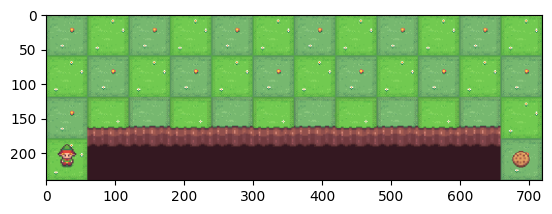

In [30]:
env = gym.make("CliffWalking-v0", render_mode='rgb_array')
env.reset()
img = env.render()
plt.imshow(img)  # type: ignore
plt.show()

In [32]:
from gymnasium.utils import play

In [ ]:
# There also is a play utility (somewhat clunky for cliff walk)
env = gym.make("CliffWalking-v0", render_mode='rgb_array')
env.reset()

keyDict = {
    'w': 0,
    'd': 1,
    's': 2,
    'a': 3
}

# play.play(env, fps=2, keys_to_action=keyDict, noop=3) # type: ignore

## Solving the cliff walk

Below, we re-implement SARSA and Q-learning, adapted to the gym API.

In [11]:
# # env = gym.make('CliffWalking-v0', render_mode='ansi')
# env = gym.make('FrozenLake-v1', render_mode='ansi')
# # env = gym.make('Blackjack-v1')
# env.reset()
# print(env.render())

In [12]:
ALPHA = 0.1
EPSILON = 0.1
GAMMA = 1

N = 30000

DEFAULT_QVALUE = 100

Some utility functions:

In [13]:
def makeEmptyQofS():
    # Shape only works for discrete action spaces with start==0
    return [DEFAULT_QVALUE] * env.action_space.n

def chooseEpsilonGreedy(qValues, eps):
    if np.random.uniform() < eps:
        return np.random.choice(len(qValues))
    return np.argmax(qValues)


SARSA:

In [14]:
def sarsaEpisode(env: gym.Env, qDict):
    done = False
    (state, *_) = env.reset()
    action = chooseEpsilonGreedy(qDict[state], EPSILON)
    
    totalRewards = 0.0
    
    while not done:
        (newState, reward, done, *_) = env.step(action)
        newAction = chooseEpsilonGreedy(qDict[newState], EPSILON)
        
        target = reward + GAMMA * qDict[newState][newAction] * (not done)
        oldQ = qDict[state][action]
        
        qDict[state][action] = oldQ + ALPHA * (target - oldQ)
        
        state = newState
        action = newAction
        
        totalRewards += float(reward)
        
    return totalRewards

In [15]:
sarsaQDict = defaultdict(makeEmptyQofS)
sarsaRewards = []

for i in range(N):
    reward = sarsaEpisode(env, sarsaQDict)
    sarsaRewards.append(reward)

Q-learning:

In [16]:
def qLearningEpisode(env: gym.Env, qDict):
    done = False
    totalRewards = 0.0
    (state, *_) = env.reset()

    while not done:
        action = chooseEpsilonGreedy(qDict[state], EPSILON)
        (newState, reward, done, *_) = env.step(action)
        target = reward + GAMMA * np.max(qDict[newState]) * (not done)
        oldQ = qDict[state][action]
        
        newQ = oldQ + ALPHA * (target - oldQ)
        
        qDict[state][action] = newQ

        state = newState
        
        totalRewards += float(reward)
    
    return totalRewards

In [17]:
qLearningQDict = defaultdict(makeEmptyQofS)
qLearningRewards = []

for i in range(N):
    reward = qLearningEpisode(env, qLearningQDict)
    qLearningRewards.append(reward)

Compare results:

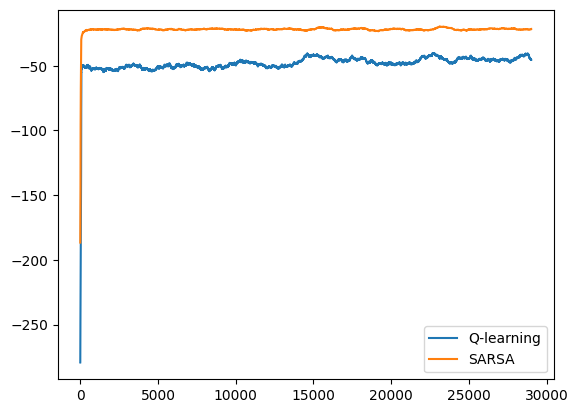

In [18]:
%matplotlib inline

def movingAverage(a, k):
    return np.convolve(a, np.ones(k), 'valid') / k
    
# Plot (moving average) of per-episode rewards
N_AVERAGE = 1000
plt.figure()
plt.plot(movingAverage(qLearningRewards, N_AVERAGE), label='Q-learning')
plt.plot(movingAverage(sarsaRewards, N_AVERAGE), label='SARSA')
plt.legend()
plt.show()


In [ ]:
def playGreedyGame(env: gym.Env, qDict):
    done = False
    totalRewards = 0.0
    (state, *_) = env.reset()

    while not done:
        action = chooseEpsilonGreedy(qDict[state], 0.0)
        (state, reward, done, *_) = env.step(action)
        totalRewards += float(reward)

    return totalRewards

In [20]:
def playGreedyGames(env: gym.Env, qDict, nGames):
    rewards = []
    for n in range(nGames):
        rewards.append(playGreedyGame(env, qDict))
    return rewards

In [28]:
playGreedyGame(env, sarsaQDict)
playGreedyGame(env, qLearningQDict)

-13.0

In [27]:
# qLearningQDict

In [23]:
N_GREEDY = 100


sarsaGreedyRewards = playGreedyGames(env, sarsaQDict, N_GREEDY)
qLearningGreedyRewards = playGreedyGames(env, qLearningQDict, N_GREEDY)

print(np.mean(sarsaGreedyRewards))
print(np.mean(qLearningGreedyRewards))


-17.0
-13.0
